# RTS vs BIFM Smoothing
___Credits to Martin de Quincey___

This notebook performs Kalman smoothing on a factor graph using message passing, based on the BIFM Kalman smoother. This notebook is based on:

1. F. Wadehn, “State Space Methods with Applications in Biomedical Signal Processing,” ETH Zurich, 2019. Accessed: Jun. 16, 2021. [Online]. Available: https://www.research-collection.ethz.ch/handle/20.500.11850/344762
2. H. Loeliger, L. Bruderer, H. Malmberg, F. Wadehn, and N. Zalmai, “On sparsity by NUV-EM, Gaussian message passing, and Kalman smoothing,” in 2016 Information Theory and Applications Workshop (ITA), Jan. 2016, pp. 1–10. doi: 10.1109/ITA.2016.7888168.

We perform Kalman smoothing in the linear state space model, represented by
$$Z_{k+1} = A Z_k + B U_k$$
$$Y_k = C Z_k + W_k$$
with observations $Y_k$, latent states $Z_k$ and inputs $U_k$. $W_k$ is the observation noise. $A \isin \mathrm{R}^{n \times n}$, $B \isin \mathrm{R}^{n \times m}$ and $C \isin \mathrm{R}^{d \times n}$ are the transition matrices in the model. Here $n$, $m$ and $d$ denote the dimensionality of the latent, input and output dimension, respectively.

The corresponding probabilistic model can be represented as 
$$
    \begin{split}
        p(y,\ z,\ u)
        &= p(z_0) \prod_{k=1}^N p(y_k \mid z_k)\ p(z_k\mid z_{k-1},\ u_{k-1})\ p(u_{k-1}) \\
        &= \mathcal{N}(z_0 \mid \mu_{z_0}, \Sigma_{z_0}) \left( \prod_{k=1}^N \mathcal{N}(y_k \mid C z_k,\ \Sigma_W)\ \delta(z_k - (Az_{k-1} + Bu_{k-1})) \mathcal{N}(u_{k-1} \mid \mu_{i_{k-1}},\ \Sigma_{u_{k-1}}) \right)
    \end{split}
$$

## Import packages

In [1]:
using Random
using LinearAlgebra
using PyPlot
using Distributions
using BenchmarkTools
using ProgressMeter
using Revise

using ReactiveMP
using GraphPPL
using Rocket;

## Data generation

In [2]:
function generate_parameters(dim_out::Int64, dim_in::Int64, dim_lat::Int64; seed::Int64 = 123)
    
    # define noise levels
    input_noise  = 500.0
    output_noise = 50.0

    # create random generator for reproducibility
    rng = MersenneTwister(seed)

    # generate matrices, input statistics and noise matrices
    A      = diagm(0.8 .* ones(dim_lat) .+ 0.2 * rand(rng, dim_lat))                                            # size (dim_lat x dim_lat)
    B      = rand(dim_lat, dim_in)                                                                              # size (dim_lat x dim_in)
    C      = rand(dim_out, dim_lat)                                                                             # size (dim_out x dim_lat)
    μu     = rand(dim_in) .* collect(1:dim_in)                                                                  # size (dim_in x 1)
    Σu     = input_noise  .* collect(Hermitian(randn(rng, dim_in, dim_in) + diagm(10 .+ 10*rand(dim_in))))      # size (dim_in x dim_in)
    Σy     = output_noise .* collect(Hermitian(randn(rng, dim_out, dim_out) + diagm(10 .+ 10*rand(dim_out))))   # size (dim_out x dim_out)
    Wu     = cholinv(Σu)
    Wy     = cholinv(Σy)
    
    # return parameters
    return A, B, C, μu, Σu, Σy, Wu, Wy

end;

In [3]:
function generate_data(nr_samples::Int64, A::Array{Float64,2}, B::Array{Float64,2}, C::Array{Float64,2}, μu::Array{Float64,1}, Σu::Array{Float64,2}, Σy::Array{Float64,2}; seed::Int64 = 123)
        
    # create random data generator
    rng = MersenneTwister(seed)
    
    # preallocate space for variables
    z = Vector{Vector{Float64}}(undef, nr_samples)
    y = Vector{Vector{Float64}}(undef, nr_samples)
    u = rand(rng, MvNormal(μu, Σu), nr_samples)'
    
    # set initial value of latent states
    z_prev = zeros(size(A,1))
    
    # generate data
    for i in 1:nr_samples

        # generate new latent state
        z[i] = A * z_prev + B * u[i,:]

        # generate new observation
        y[i] = C * z[i] + rand(rng, MvNormal(zeros(dim_out), Σy))
        
        # generate new observation
        z_prev .= z[i]
        
    end
    
    # return generated data
    return z, y, u
    
end;

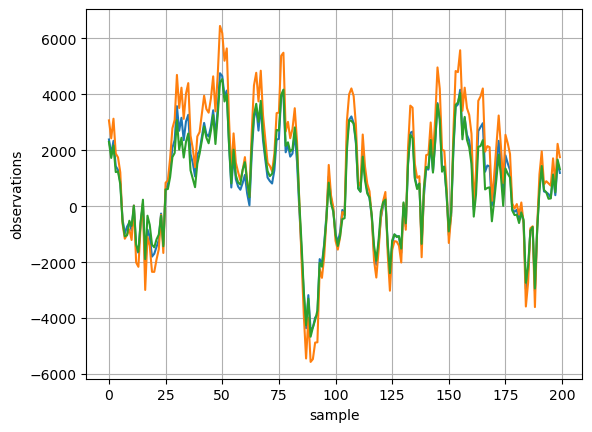

In [4]:
# specify settings
nr_samples = 200
dim_out = 3
dim_in = 3
dim_lat = 25

# generate parameters
A, B, C, μu, Σu, Σy, Wu, Wy = generate_parameters(dim_out, dim_in, dim_lat);
            
# generate data
data_z, data_y, data_u = generate_data(nr_samples, A, B, C, μu, Σu, Σy);

# visualise data
plt.plot(data_y)
plt.grid()
plt.xlabel("sample")
plt.ylabel("observations");

## Model specification

In [5]:
@model function RTS_smoother(nr_samples::Int64, A::Array{Float64,2}, B::Array{Float64,2}, C::Array{Float64,2}, μu::Array{Float64,1}, Wu::Array{Float64,2}, Wy::Array{Float64,2})
    
    # fetch dimensionality
    dim_lat = size(A, 1)
    dim_out = size(C, 1)
    
    # initialize variables
    z = randomvar(nr_samples)                 # hidden states (random variable)
    u = randomvar(nr_samples)                 # inputs (random variable)
    y = datavar(Vector{Float64}, nr_samples)  # outputs (observed variables)
    
    # set initial hidden state
    z_prior ~ MvNormalMeanPrecision(zeros(dim_lat), 1e-5*diagm(ones(dim_lat)))
    
    # update last/previous hidden state
    z_prev = z_prior

    # loop through observations
    for i in 1:nr_samples

        # specify input as random variable
        u[i] ~ MvNormalMeanPrecision(μu, Wu)
        
        # specify updated hidden state
        z[i] ~ A * z_prev + B * u[i]
        
        # specify observation
        y[i] ~ MvNormalMeanPrecision(C * z[i], Wy)
        
        # update last/previous hidden state
        z_prev = z[i]

    end
    
    # return parameters of interest
    return z, y, u
    
end;

In [6]:
@model function BIFM_smoother(nr_samples::Int64, A::Array{Float64,2}, B::Array{Float64,2}, C::Array{Float64,2}, μu::Array{Float64,1}, Wu::Array{Float64,2}, Wy::Array{Float64,2})

    # fetch dimensionality
    dim_lat = size(A, 1)
    
    # initialize variables
    z  = randomvar(nr_samples)                  # latent states
    yt = randomvar(nr_samples)                  # latent observations
    y  = datavar(Vector{Float64}, nr_samples)   # actual observations
    u  = randomvar(nr_samples)                  # inputs
    
    # set priors
    z_prior ~ MvNormalMeanPrecision(zeros(dim_lat), 1e-5*diagm(ones(dim_lat)))
    z_tmp   ~ BIFMHelper(z_prior) where { q = MeanField()}
    
    # update last/previous hidden state
    z_prev = z_tmp
    
    # loop through observations
    for i in 1:nr_samples

        # specify input as random variable
        u[i]   ~ MvNormalMeanPrecision(μu, Wu)

        # specify observation
        yt[i]  ~ BIFM(u[i], z_prev, z[i]) where { meta = BIFMMeta(A, B, C) }
        y[i]   ~ MvNormalMeanPrecision(yt[i], Wy)
        
        # update last/previous hidden state
        z_prev = z[i]

    end
    
    # set final value
    z[nr_samples] ~ MvNormalMeanPrecision(zeros(dim_lat), zeros(dim_lat, dim_lat))
    
    # return parameters of interest
    return z, y, u
    
end;

## Probabilistic inference

In [7]:
function inference_RTS(data_y::Array{Array{Float64,1},1}, A::Array{Float64,2}, B::Array{Float64,2}, C::Array{Float64,2}, μu::Array{Float64,1}, Wu::Array{Float64,2}, Wy::Array{Float64,2})
    
    # define model
    model, (z, y, u) = RTS_smoother(nr_samples, A, B, C, μu, Wu, Wy)
    
    # initialize buffer for latent states
    mz = buffer(Marginal, nr_samples)
    my = buffer(Marginal, nr_samples)
    mu = buffer(Marginal, nr_samples)
    
    # subscribe to z
    z_sub = subscribe!(getmarginals(z), mz)
    y_sub = subscribe!(getmarginals(y), my)
    u_sub = subscribe!(getmarginals(u), mu)

    # update y according to observations (i.e. perform inference)
    ReactiveMP.update!(y, data_y)
    
    # unsubscribe
    unsubscribe!([z_sub, y_sub, u_sub])
    
    # return the marginal values
    return getvalues(mz), getvalues(my), getvalues(mu)

end;

In [8]:
function inference_BIFM(data_y::Array{Array{Float64,1},1}, A::Array{Float64,2}, B::Array{Float64,2}, C::Array{Float64,2}, μu::Array{Float64,1}, Wu::Array{Float64,2}, Wy::Array{Float64,2})  

    # define model
    model, (z, y, u) = BIFM_smoother(nr_samples, A, B, C, μu, Wu, Wy)
    
    # initialize buffer for latent states
    mz = buffer(Marginal, nr_samples)
    my = buffer(Marginal, nr_samples)
    mu = buffer(Marginal, nr_samples)

    # Note: When performing inference, first subscribe to the marginals (in the order: z, out, in) and then to the free energy score function.

    # subscribe to z
    z_sub = subscribe!(getmarginals(z), mz)
    y_sub = subscribe!(getmarginals(y), my)
    u_sub = subscribe!(getmarginals(u), mu)
    
    # update y according to observations
    ReactiveMP.update!(y, data_y)
    
    # when done, unsubscribe
    unsubscribe!([z_sub, y_sub, u_sub])
    
    # return the marginal values
    return getvalues(mz), getvalues(my), getvalues(mu)

end;

## Experiments for 200 observations

In [9]:
z_RTS, y_RTS, u_RTS = inference_RTS(data_y, A, B, C, μu, Wu, Wy)
z_BIFM, y_BIFM, u_BIFM = inference_BIFM(data_y, A, B, C, μu, Wu, Wy);

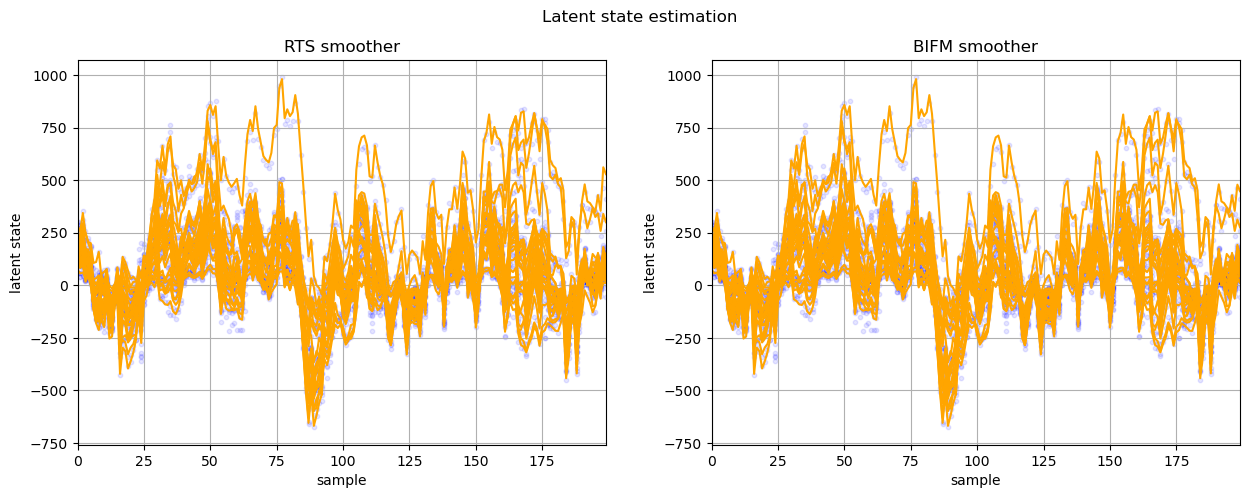

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].plot(mean.(z_RTS), c="orange")
ax[1].scatter(repeat(0:nr_samples-1, 1, dim_lat)', hcat(data_z...), c="blue", s=10, alpha=0.1)
ax[2].plot(mean.(z_BIFM), c="orange")
ax[2].scatter(repeat(0:nr_samples-1, 1, dim_lat)', hcat(data_z...), c="blue", s=10, alpha=0.1)
ax[1].grid(), ax[2].grid()
ax[1].set_xlabel("sample"), ax[2].set_xlabel("sample")
ax[1].set_ylabel("latent state"), ax[2].set_ylabel("latent state")
ax[1].set_xlim(0, nr_samples-1), ax[2].set_xlim(0, nr_samples-1)
ax[1].set_title("RTS smoother"), ax[2].set_title("BIFM smoother")
fig.suptitle("Latent state estimation");

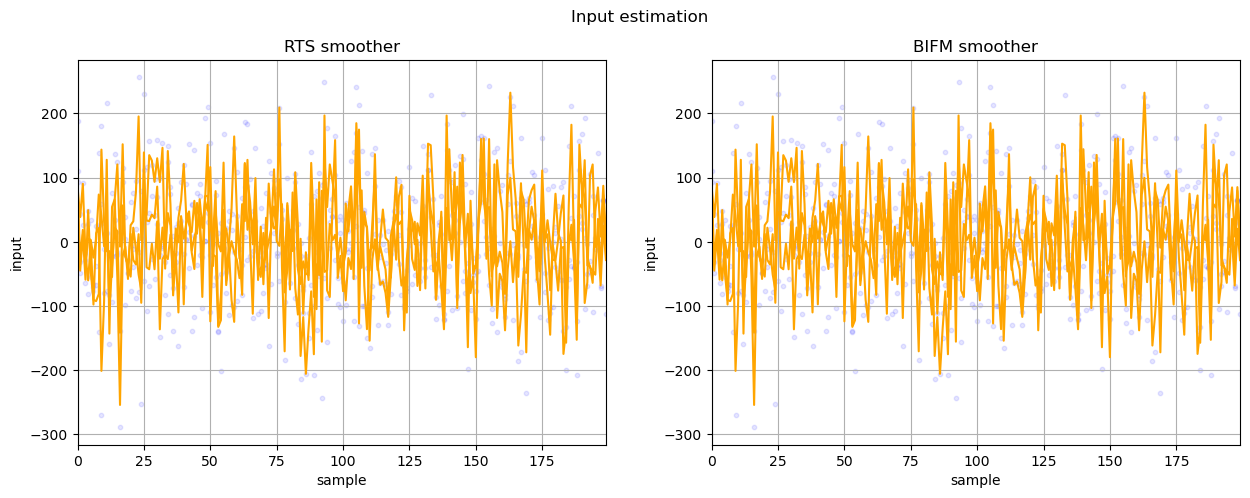

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].plot(mean.(u_RTS), c="orange")
ax[1].scatter(repeat(0:nr_samples-1, 1, dim_in)', hcat(data_u...), c="blue", s=10, alpha=0.1)
ax[2].plot(mean.(u_BIFM), c="orange")
ax[2].scatter(repeat(0:nr_samples-1, 1, dim_in)', hcat(data_u...), c="blue", s=10, alpha=0.1)
ax[1].grid(), ax[2].grid()
ax[1].set_xlabel("sample"), ax[2].set_xlabel("sample")
ax[1].set_ylabel("input"), ax[2].set_ylabel("input")
ax[1].set_xlim(0, nr_samples-1), ax[2].set_xlim(0, nr_samples-1)
ax[1].set_title("RTS smoother"), ax[2].set_title("BIFM smoother")
fig.suptitle("Input estimation");

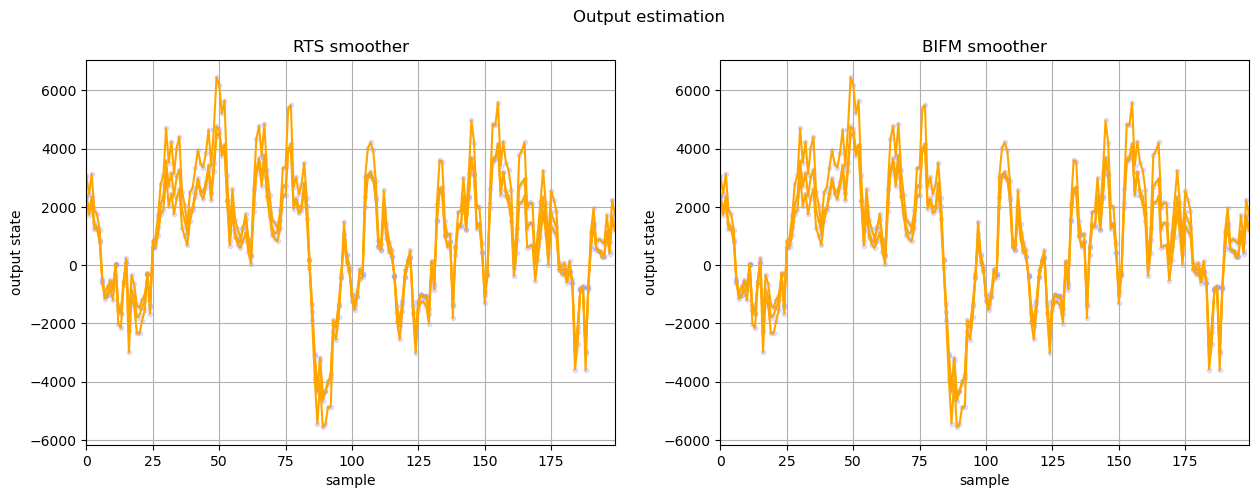

In [12]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].plot(mean.(y_RTS), c="orange")
ax[1].scatter(repeat(0:nr_samples-1, 1, dim_out)', hcat(data_y...), c="blue", s=10, alpha=0.1)
ax[2].plot(mean.(y_BIFM), c="orange")
ax[2].scatter(repeat(0:nr_samples-1, 1, dim_out)', hcat(data_y...), c="blue", s=10, alpha=0.1)
ax[1].grid(), ax[2].grid()
ax[1].set_xlabel("sample"), ax[2].set_xlabel("sample")
ax[1].set_ylabel("output state"), ax[2].set_ylabel("output state")
ax[1].set_xlim(0, nr_samples-1), ax[2].set_xlim(0, nr_samples-1)
ax[1].set_title("RTS smoother"), ax[2].set_title("BIFM smoother")
fig.suptitle("Output estimation");

## Benchmark

In [13]:
trials_RTS  = Array{BenchmarkTools.Trial, 1}(undef, 50)
trials_BIFM = Array{BenchmarkTools.Trial, 1}(undef, 50)

@showprogress for k = 1 : 50

    # generate parameters
    A, B, C, μu, Σu, Σy, Wu, Wy = generate_parameters(3, 3, k);
                
    # generate data|
    data_z, data_y, data_u = generate_data(200, A, B, C, μu, Σu, Σy);

    # run inference
    trials_RTS[k] = @benchmark inference_RTS($data_y, $A, $B, $C, $μu, $Wu, $Wy)
    trials_BIFM[k] = @benchmark inference_BIFM($data_y, $A, $B, $C, $μu, $Wu, $Wy)

end

m_RTS = [median(trials_RTS[k].times) for k=1:50] ./ 1e9
q1_RTS = [quantile(trials_RTS[k].times, 0.25) for k=1:50] ./ 1e9
q3_RTS = [quantile(trials_RTS[k].times, 0.75) for k=1:50] ./ 1e9
m_BIFM = [median(trials_BIFM[k].times) for k=1:50] ./ 1e9
q1_BIFM = [quantile(trials_BIFM[k].times, 0.25) for k=1:50] ./ 1e9
q3_BIFM = [quantile(trials_BIFM[k].times, 0.75) for k=1:50] ./ 1e9;

Progress: 100%|█████████████████████████████████████████| Time: 0:19:57


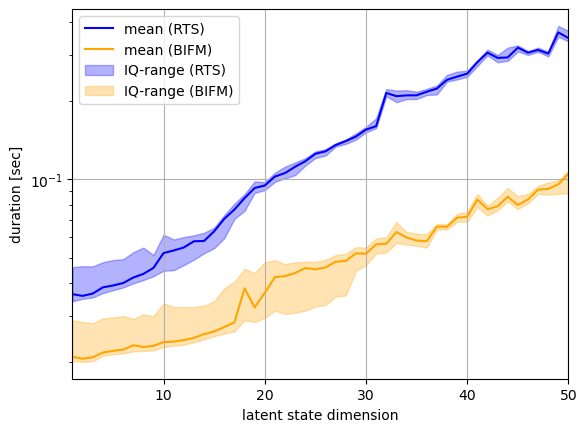

In [14]:
plt.figure()
plt.plot(1:50, m_RTS, color="blue", label="mean (RTS)")
plt.fill_between(1:50, q1_RTS, q3_RTS, color="blue", alpha=0.3, label="IQ-range (RTS)")
plt.plot(1:50, m_BIFM, color="orange", label="mean (BIFM)")
plt.fill_between(1:50, q1_BIFM, q3_BIFM, color="orange", alpha=0.3, label="IQ-range (BIFM)")
plt.yscale("log")
plt.grid()
plt.xlabel("latent state dimension")
plt.ylabel("duration [sec]")
plt.legend()
plt.xlim(1, 50);